In [52]:
import pandas as pd
# 데이터를 읽어봅시다.
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')


train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [53]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 1. 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # 2. NaN 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')
    
    # 3. 한국어 토크나이저로 토큰화
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        X_train.append(temp_X)
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        X_test.append(temp_X)
    
    # 4. 불용어(Stopwords) 제거
    X_train = [[word for word in sentence if not word in stopwords] for sentence in X_train]
    X_test = [[word for word in sentence if not word in stopwords] for sentence in X_test]
    
    # 5. 사전word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}
    
    # 6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # 7. X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [54]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [55]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

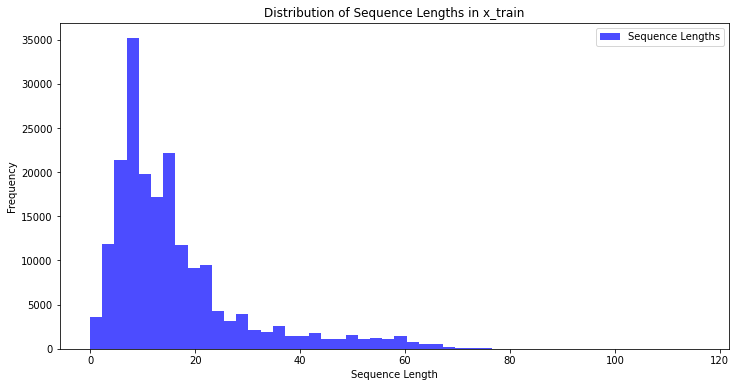

In [56]:
import matplotlib.pyplot as plt

# X_train에 포함된 각 시퀀스의 길이를 계산
total_data_text = list(X_train) + list(X_test) # 텍스트데이터 전체 문장길이 리스트
num_tokens =  np.array([len(tokens) for tokens in total_data_text]) # 배열로 변환하여 토큰 길이 계산

# 히스토그램으로 시퀀스 길이 분포를 표시
plt.figure(figsize=(12, 6))
plt.hist(num_tokens, bins=50, alpha=0.7, color='blue', label='Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths in x_train')
plt.legend()
plt.show()



In [57]:
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  54
전체 문장의 0.9720946661956905%가 maxlen 설정값 이내에 포함됩니다. 


In [58]:
maxlen = 54 # 최대 문장 길이

In [59]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=maxlen)


In [60]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - RNN 모델
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(4))   # 차원 수를 4로 줄임으로써 결과가 개선됨
model.add(tf.keras.layers.Dense(8, activation='relu'))
# model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))) # L2 정규화 적용
model.add(tf.keras.layers.Dropout(0.7)) # DropOut 적용
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 4)                 336       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 160,385
Trainable params: 160,385
Non-trainable params: 0
_________________________________________________________________


In [61]:
# validation set 50000건 분리
x_val = X_train[:50000]
y_val = y_train[:50000]

# validation set을 제외한 나머지 9만여 건
partial_x_train = X_train[50000:]
partial_y_train = y_train[50000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(96182, 54)
(96182,)


In [62]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # 조기 종료 적용

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping]) # 조기 종료 콜백 옵션

Epoch 1/20
188/188 [==============================] - 3s 9ms/step - loss: 0.6924 - accuracy: 0.5027 - val_loss: 0.6700 - val_accuracy: 0.5705
Epoch 2/20
188/188 [==============================] - 1s 7ms/step - loss: 0.5700 - accuracy: 0.7266 - val_loss: 0.4461 - val_accuracy: 0.8367
Epoch 3/20
188/188 [==============================] - 1s 7ms/step - loss: 0.4955 - accuracy: 0.7894 - val_loss: 0.4012 - val_accuracy: 0.8459
Epoch 4/20
188/188 [==============================] - 1s 7ms/step - loss: 0.4695 - accuracy: 0.7994 - val_loss: 0.3918 - val_accuracy: 0.8468
Epoch 5/20
188/188 [==============================] - 1s 7ms/step - loss: 0.4526 - accuracy: 0.8036 - val_loss: 0.3894 - val_accuracy: 0.8436
Epoch 6/20
188/188 [==============================] - 1s 7ms/step - loss: 0.4409 - accuracy: 0.8085 - val_loss: 0.3845 - val_accuracy: 0.8404
Epoch 7/20
188/188 [==============================] - 1s 7ms/step - loss: 0.4341 - accuracy: 0.8097 - val_loss: 0.3914 - val_accuracy: 0.8454
Epoch 

In [63]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4481 - accuracy: 0.8375
[0.44809722900390625, 0.8374798893928528]


In [64]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


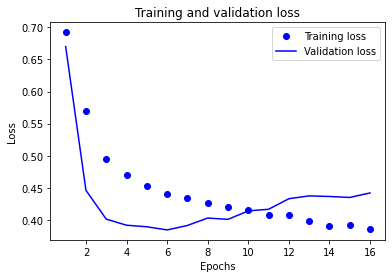

In [65]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [66]:
from tensorflow.keras.initializers import Constant

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# 모델 구성ㅡ CNN 모델
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen,
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 54, 16)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 16)            1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [51]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # 조기 종료 적용

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping]) # 조기 종료 콜백 옵션

Epoch 1/20
188/188 [==============================] - 3s 9ms/step - loss: 0.6930 - accuracy: 0.5020 - val_loss: 0.6930 - val_accuracy: 0.5011
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.6930 - accuracy: 0.5020 - val_loss: 0.6930 - val_accuracy: 0.5011
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.6930 - accuracy: 0.5002 - val_loss: 0.6930 - val_accuracy: 0.5011
Epoch 4/20
157/188 [========================>.....] - ETA: 0s - loss: 0.6930 - accuracy: 0.5017

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


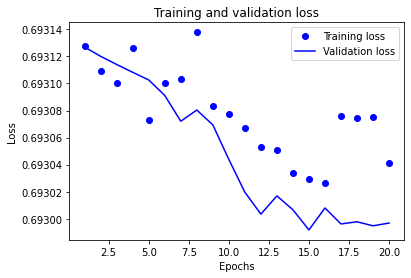

In [50]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [102]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4240 - accuracy: 0.8353
[0.4239587187767029, 0.8353438973426819]


In [103]:
# GlobalMaxPooling 레이어 단일 사용

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # 조기 종료 적용

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping]) # 조기 종료 콜백 옵션

Epoch 1/20
188/188 [==============================] - 1s 5ms/step - loss: 0.6926 - accuracy: 0.5277 - val_loss: 0.6918 - val_accuracy: 0.5371
Epoch 2/20
188/188 [==============================] - 1s 4ms/step - loss: 0.6910 - accuracy: 0.5395 - val_loss: 0.6906 - val_accuracy: 0.5371
Epoch 3/20
188/188 [==============================] - 1s 4ms/step - loss: 0.6902 - accuracy: 0.5395 - val_loss: 0.6902 - val_accuracy: 0.5372
Epoch 4/20
188/188 [==============================] - 1s 4ms/step - loss: 0.6899 - accuracy: 0.5398 - val_loss: 0.6902 - val_accuracy: 0.5375
Epoch 5/20
188/188 [==============================] - 1s 4ms/step - loss: 0.6898 - accuracy: 0.5400 - val_loss: 0.6901 - val_accuracy: 0.5375
Epoch 6/20
188/188 [==============================] - 1s 4ms/step - loss: 0.6897 - accuracy: 0.5399 - val_loss: 0.6900 - val_accuracy: 0.5375
Epoch 7/20
188/188 [==============================] - 1s 4ms/step - loss: 0.6897 - accuracy: 0.5401 - val_loss: 0.6900 - val_accuracy: 0.5377
Epoch 

In [105]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)ac

1537/1537 - 2s - loss: 0.6899 - accuracy: 0.5366
[0.6898621916770935, 0.5365868806838989]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


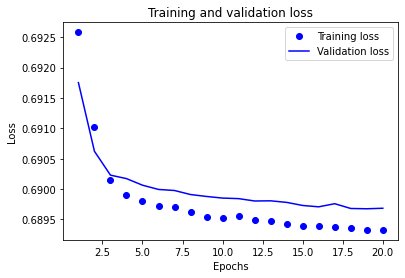

In [106]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [67]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = './word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [12]:
similar_words = word_vectors.wv.most_similar("사랑", topn=10)
similar_words

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [103]:
word_vector_dim = 100 
embedding_matrix = np.zeros((vocab_size, word_vector_dim))

for word, i in word_to_index.items():
    if i < vocab_size:
        try:
            embedding_vector = word_vectors.wv[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            continue

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
                                    input_shape=(None,), 
                                    trainable=False))  # trainable을 True로 설정하면 Fine-tuning이 가능합니다.
model.add_loss(lambda: tf.keras.regularizers.l2(0.0001)(model.layers[0].embeddings))
model.add(tf.keras.layers.LSTM(12, return_sequences=True)) # 레이어 증가
model.add(tf.keras.layers.LSTM(8, return_sequences=True)) # 레이어 한겹 추가
model.add(tf.keras.layers.GRU(8)) # GRU 레이어
model.add(tf.keras.layers.Dense(12, activation='leaky_relu')) # Leaky ReLU 추가
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [108]:
from adabelief_tf import AdaBeliefOptimizer # AdaBelief 옵티마이저


# optimizer = tf.keras.optimizers.Adam(learning_rate=0.005) # 학습률 조정
ptimizer = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False) # Ada_Belief 옵티마이저 사용
model.compile(optimizer=optimizer,
# model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=30  # 에포크 증가
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # 조기 종료 적용

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping]) # 조기 종료 콜백 옵션

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Epoch 1/30
188/188 [==============================] - 7s 18ms/step - loss: 225.3147 - accuracy: 0

In [109]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 225.2582 - accuracy: 0.8311
[225.25820922851562, 0.8310718536376953]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


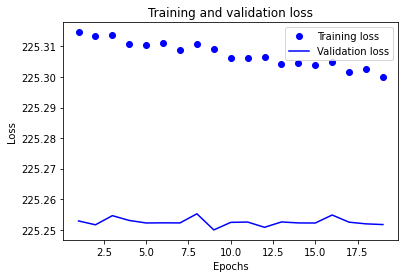

In [110]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 회고
모델은 RNN만 썼지만 하이퍼파라미터(레이어 수, 학습률)를 여러 가지로 시도하고, 옵티마이저도 바꾸어보고, ReLU 함수 대신 다른 활성화 함수를 써보기도 하고 다양한 시도를 했다. 85%라는 학습률이 나오지 않아서 이를 기준으로 제시했구나 라는 생각이 끝날 무렵에 들었다. 아마 데이터 자체의 한계일수도 있고 (처음에 뽑은 헤드 5개 리뷰를 보면 긍/부정이 부적절하게 분류되어 있는 것으로 보인다) 뭔가 다른 접근법이 있는 것일지도 모르겠다.

사실 정확히 뭐가 뭔지는 잘 모르겠다는 느낌이 여전히 있으나, 어떤 시도를 어떻게 할 수 있는지 코드로 옵션을 조작해보는 경험은 유의미했다.